In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

In [2]:
!conda install openpyxl -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
file = 'NIHMS914863-supplement-1.xlsx'
df = pd.read_excel(file)
df

,test_id,gene,SGCore_FPKM,Total_FPKM,Fold change,Localization,test_stat,p_value,q_value,significant,Number of RNA molecules in SGs per cell,Number of RNA molecules in cell,Fraction of RNA molecules in SGs,Translation efficiency,Transcript length,5'UTR length,3'UTR length,CDS length,GC content,Mito
0,ENSG00000186205,42795,4.13560,4.32935,0.955247,Neither,0.109442,0.84215,0.899399,no,0.379622,3.387598,0.112062,NaN,7439,185.0,6238.0,1014,45.28,NaN
1,ENSG00000117791,42796,3.04748,3.08514,0.987793,Neither,0.025397,0.96565,0.975594,no,0.279739,2.414038,0.115880,NaN,2134,306.0,297.0,1008,44.02,NaN
2,ENSG00000099785,42796,1.72876,5.64139,0.306442,depleted,4.062400,0.00005,0.000236,yes,0.158689,4.414233,0.035949,NaN,1667,402.0,457.0,741,51.12,NaN
3,ENSG00000173926,42797,2.43946,2.72078,0.896603,Neither,0.313164,0.58485,0.714694,no,0.223927,2.128936,0.105183,NaN,4196,458.0,244.0,762,40.98,NaN
4,ENSG00000144583,42798,16.85970,8.32921,2.024166,enriched,-4.969160,0.00005,0.000236,yes,1.547613,6.517379,0.237459,NaN,4447,1766.0,1446.0,1233,44.44,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11190,ENSG00000070476,ZXDC,20.70570,7.89063,2.624087,enriched,-6.474060,0.00005,0.000236,yes,1.900652,6.174202,0.307838,0.540614,4639,53.0,258.0,2577,48.68,Tnon_mito
11191,ENSG00000162378,ZYG11B,8.96261,4.94965,1.810756,Neither,-2.137040,0.00110,0.004092,yes,0.822711,3.872966,0.212424,0.688947,8093,186.0,5712.0,2235,41.29,Tnon_mito
11192,ENSG00000159840,ZYX,84.81970,69.66490,1.217539,Neither,-1.131150,0.04900,0.115330,no,7.785910,54.510876,0.142832,5.505938,2493,329.0,NaN,1719,58.32,Tnon_mito
11193,ENSG00000074755,ZZEF1,19.07850,4.32639,4.409797,enriched,-5.088930,0.00005,0.000236,yes,1.751285,3.385282,0.517323,0.399204,11456,124.0,NaN,8886,44.49,Tnon_mito


In [4]:
print(df.shape)
print(df.columns)

(11195, 20)
Index(['test_id', 'gene', 'SGCore_FPKM', 'Total_FPKM', 'Fold change',
       'Localization', 'test_stat', 'p_value', 'q_value', 'significant',
       'Number of RNA molecules in SGs per cell',
       'Number of RNA molecules in cell', 'Fraction of RNA molecules in SGs',
       'Translation efficiency', 'Transcript length', '5'UTR length',
       '3'UTR length', 'CDS length', 'GC content', 'Mito'],
      dtype='object')


In [5]:
#separate mRNA features from target
feature_cols = ['Transcript length', "5'UTR length", "3'UTR length", 'CDS length', 'GC content'] #too many NaN values for translation efficiency so not using
target_col = 'Fraction of RNA molecules in SGs'

X = df[feature_cols]
y = df[target_col]

print(X)
print(y)

       Transcript length  5'UTR length  3'UTR length  CDS length  GC content
0                   7439         185.0        6238.0        1014       45.28
1                   2134         306.0         297.0        1008       44.02
2                   1667         402.0         457.0         741       51.12
3                   4196         458.0         244.0         762       40.98
4                   4447        1766.0        1446.0        1233       44.44
...                  ...           ...           ...         ...         ...
11190               4639          53.0         258.0        2577       48.68
11191               8093         186.0        5712.0        2235       41.29
11192               2493         329.0           NaN        1719       58.32
11193              11456         124.0           NaN        8886       44.49
11194               4737         157.0         751.0        2712       37.17

[11195 rows x 5 columns]
0        0.112062
1        0.115880
2        0.035

In [6]:
# Check for missing values
print("Missing values in mRNA features:")
print(X.isnull().sum())
print("\nMissing values in target:")
print(y.isnull().sum())


Missing values in mRNA features:
Transcript length       0
5'UTR length          101
3'UTR length         2766
CDS length              0
GC content              0
dtype: int64

Missing values in target:
0


In [7]:
#imputing mean for any NaN values
imputer = SimpleImputer(strategy='mean')
X_inputed = imputer.fit_transform(X)

In [15]:
#split data into training and test sets
#randomized 80% training, 20% test

X_train, X_test, y_train, y_test = train_test_split(
    X_inputed, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 8956
Testing set size: 2239


In [16]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Create and train the SVM model (SVR for regression)
svm_model = SVR(kernel='rbf', C=1.0, gamma='scale')

# Train the model
svm_model.fit(X_train_scaled, y_train)

print("Model trained.")

Model trained.


In [18]:
# Make predictions
y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training R² Score: {train_r2:.4f}")
print(f"Testing R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing Mean Absolute Error: {test_mae:.4f}")

Training R² Score: 0.4343
Testing R² Score: 0.3608
Training RMSE: 0.0850
Testing RMSE: 0.0906
Testing Mean Absolute Error: 0.0682


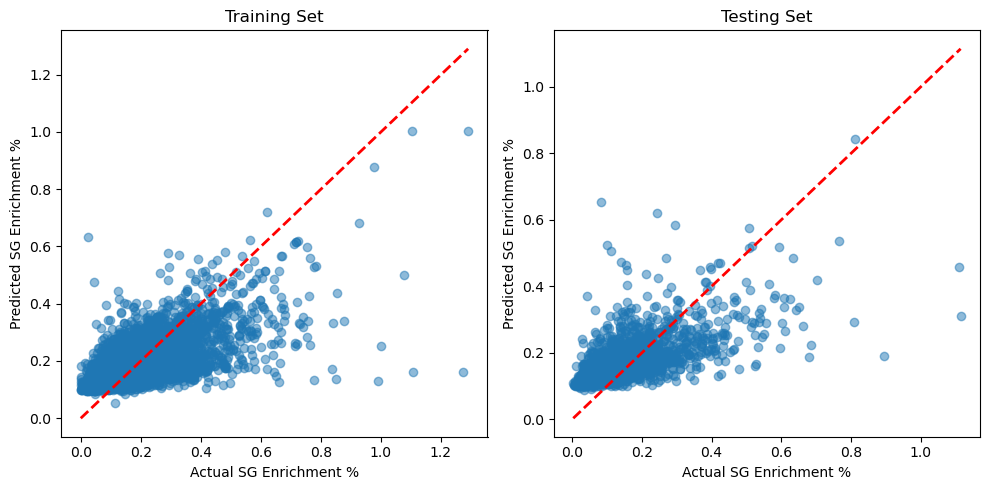

In [19]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual SG Enrichment %')
plt.ylabel('Predicted SG Enrichment %')
plt.title('Training Set')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual SG Enrichment %')
plt.ylabel('Predicted SG Enrichment %')
plt.title('Testing Set')

plt.tight_layout()
plt.show()

### Using Permutation Method to identify which features of mRNA are most important for determining SG localization.

             Feature  Importance       Std
0  Transcript length    0.313227  0.014504
3         CDS length    0.260172  0.012679
4         GC content    0.031365  0.007237
2       3'UTR length    0.029930  0.003838
1       5'UTR length    0.010652  0.005344


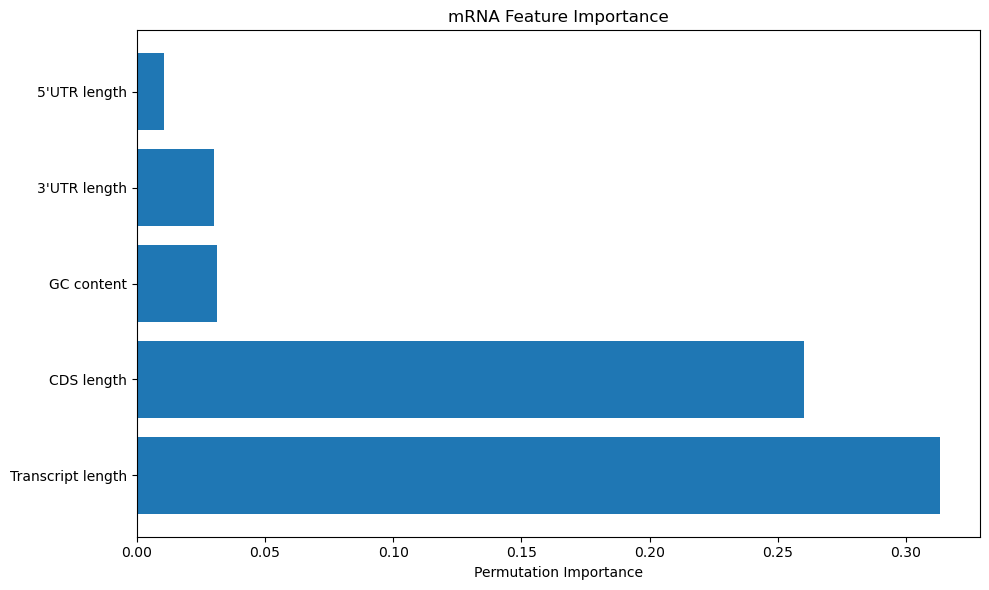

In [20]:
from sklearn.inspection import permutation_importance

# Train your model (any kernel)
model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train)

# Calculate permutation importance
perm_importance = permutation_importance(
    model, 
    X_test_scaled, 
    y_test, 
    n_repeats=10,
    random_state=42
)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print(importance_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('mRNA Feature Importance')
plt.tight_layout()
plt.show()

### Predicting localization from mRNA features

In [21]:
#target is now "localization" value
target_col2 = 'Localization'
y2 = df[target_col2]
y2

0         Neither
1         Neither
2        depleted
3         Neither
4        enriched
           ...   
11190    enriched
11191     Neither
11192     Neither
11193    enriched
11194     Neither
Name: Localization, Length: 11195, dtype: object

In [22]:
#checking for missing values
print("\nMissing values in target:")
print(y.isnull().sum())



Missing values in target:
0


In [23]:
print("Class distribution:")
print(y2.value_counts())
print(f"\nTotal samples: {len(y2)}")

Class distribution:
Localization
Neither     7789
depleted    1780
enriched    1626
Name: count, dtype: int64

Total samples: 11195


In [26]:
#splitting data
X_train, X_test, y2_train, y2_test = train_test_split(
    X_inputed, y2, test_size=0.2, random_state=42, stratify=y2  # stratify keeps class balance
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVC model
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train_scaled, y2_train)

# Make predictions
y2_pred = model.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y2_test, y2_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y2_test, y2_pred))

# Confusion matrix
cm = confusion_matrix(y2_test, y2_pred, labels=['enriched', 'depleted', 'Neither'])
print("\nConfusion Matrix:")
print(cm)


Accuracy: 0.7360

Classification Report:
              precision    recall  f1-score   support

     Neither       0.75      0.94      0.83      1558
    depleted       0.60      0.22      0.32       356
    enriched       0.72      0.31      0.43       325

    accuracy                           0.74      2239
   macro avg       0.69      0.49      0.53      2239
weighted avg       0.72      0.74      0.69      2239


Confusion Matrix:
[[ 101    2  222]
 [   0   79  277]
 [  39   51 1468]]


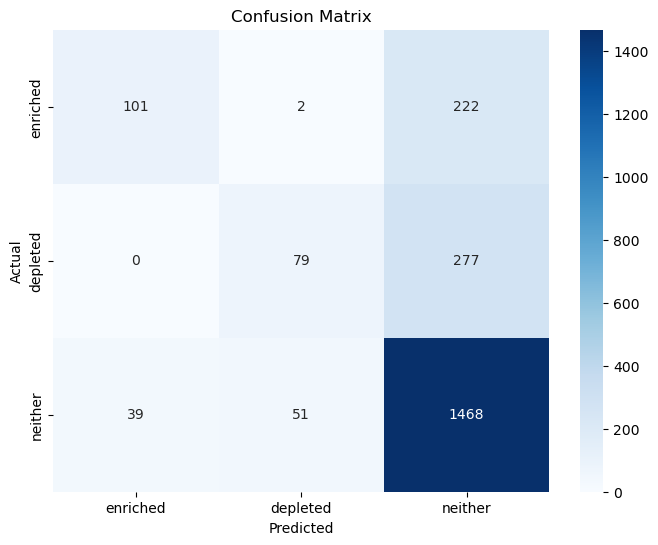

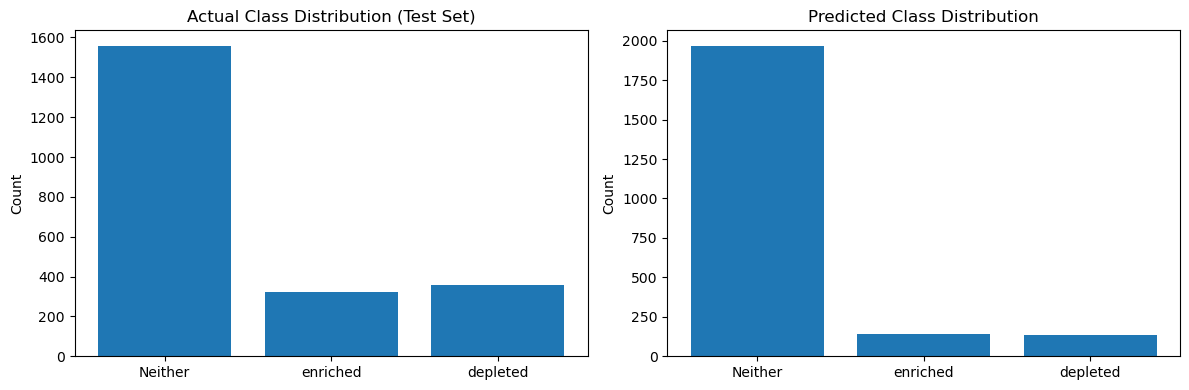

In [27]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['enriched', 'depleted', 'neither'],
    yticklabels=['enriched', 'depleted', 'neither']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot class predictions
from collections import Counter
pred_counts = Counter(y2_pred)
test_counts = Counter(y2_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Actual distribution
axes[0].bar(test_counts.keys(), test_counts.values())
axes[0].set_title('Actual Class Distribution (Test Set)')
axes[0].set_ylabel('Count')

# Predicted distribution
axes[1].bar(pred_counts.keys(), pred_counts.values())
axes[1].set_title('Predicted Class Distribution')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Importance of mRNA features for predicting SG enrichment


Feature Importance:
             Feature  Importance
3         CDS length    0.039571
0  Transcript length    0.032738
4         GC content    0.001831
2       3'UTR length    0.001161
1       5'UTR length    0.000134


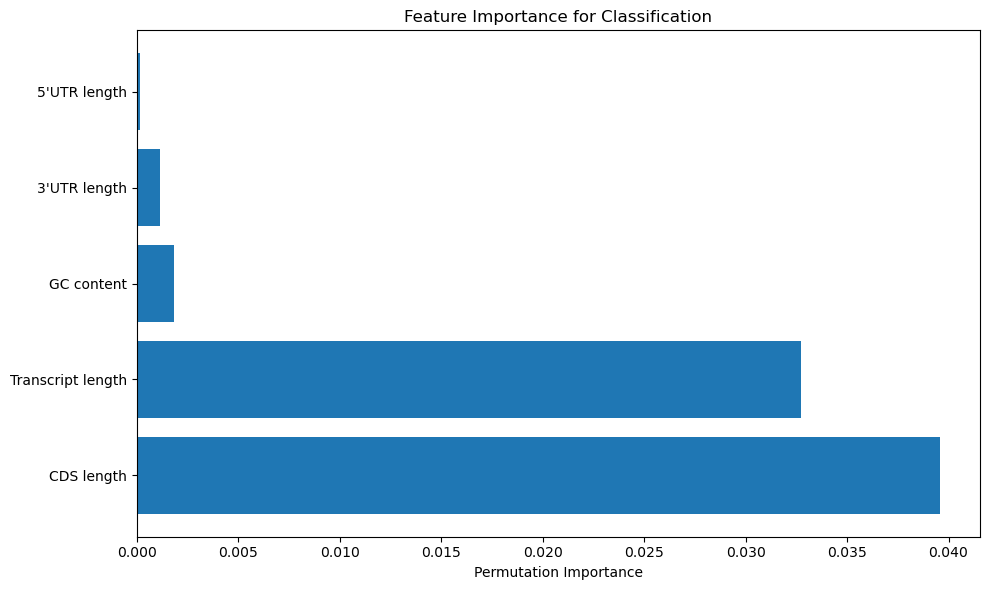

In [28]:
# Permutation importance
perm_importance = permutation_importance(
    model,
    X_test_scaled,
    y2_test,
    n_repeats=10,
    random_state=42
)

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance for Classification')
plt.tight_layout()
plt.show()